<h2>CIFAR-10 Image Classification</h2>
<h3>ST1504 Deep Learning CA1 Part B</h3>

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

### References:
- [CIFAR-100 Dataset - Keras](https://keras.io/api/datasets/cifar100/)
- [CIFAR100 Homepage](https://www.cs.toronto.edu/~kriz/cifar.html)
- [Kaggle-CIFAR100](https://www.kaggle.com/datasets/fedesoriano/cifar100)
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
    
<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>
5. Implemented Resnet50 Architecture but not enough computational power to run the code and took long. However, a set of evaluation results have been recorded<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images, with 10 labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [4]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%reload_ext tensorboard
import os
import cv2
from keras.layers import LSTM,ReLU, Dense,GaussianNoise, Bidirectional, Conv2D, AveragePooling2D, GlobalAveragePooling2D,MaxPooling2D, BatchNormalization,Add, DepthwiseConv2D,Multiply,Activation, Flatten
from tensorflow.keras.activations import swish,sigmoid
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import keras_efficientnet_v2
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import albumentations as albu
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from keras import layers
from tensorflow.keras import Sequential
import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [6]:
(x_train, y_train_fine),(x_test, y_test_fine)= tf.keras.datasets.cifar100.load_data(label_mode="fine")
(x_train, y_train_coarse),(x_test, y_test_coarse)= tf.keras.datasets.cifar100.load_data(label_mode="coarse")

x_train, x_val, y_train_fine, y_val_fine, y_train_coarse, y_val_coarse = train_test_split(
    x_train, y_train_fine, y_train_coarse, train_size=0.9, random_state=0
)

x_test = x_test/255
x_train = x_train/255
x_val = x_val/255
y_test = to_categorical(y_test_coarse,100)

print(x_train.shape, y_train_fine.shape, y_train_coarse.shape)
print(x_val.shape, y_val_fine.shape, y_val_coarse.shape)
print(x_test.shape, y_test_fine.shape, y_test_coarse.shape)

169001437/169001437 [==============================] - 20s 0us/step
(45000, 32, 32, 3) (45000, 1) (45000, 1)
(5000, 32, 32, 3) (5000, 1) (5000, 1)
(10000, 32, 32, 3) (10000, 1) (10000, 1)


* 50000 images of 32x32x3 for training and 50000 labels to pair with the images

* 10000 images of 32x32x3 for testing/validation and 10000 labels to pair with the images

In [7]:
print(pd.DataFrame(y_train_fine).value_counts().shape)
print(pd.DataFrame(y_train_coarse).value_counts().shape)

(100,)
(20,)


In [8]:
# extracting classnames
raw = """
aquatic mammals	beaver, dolphin, otter, seal, whale
fish	aquarium fish, flatfish, ray, shark, trout
flowers	orchids, poppies, roses, sunflowers, tulips
food containers	bottles, bowls, cans, cups, plates
fruit and vegetables	apples, mushrooms, oranges, pears, sweet peppers
household electrical devices	clock, computer keyboard, lamp, telephone, television
household furniture	bed, chair, couch, table, wardrobe
insects	bee, beetle, butterfly, caterpillar, cockroach
large carnivores	bear, leopard, lion, tiger, wolf
large man-made outdoor things	bridge, castle, house, road, skyscraper
large natural outdoor scenes	cloud, forest, mountain, plain, sea
large omnivores and herbivores	camel, cattle, chimpanzee, elephant, kangaroo
medium-sized mammals	fox, porcupine, possum, raccoon, skunk
non-insect invertebrates	crab, lobster, snail, spider, worm
people	baby, boy, girl, man, woman
reptiles	crocodile, dinosaur, lizard, snake, turtle
small mammals	hamster, mouse, rabbit, shrew, squirrel
trees	maple, oak, palm, pine, willow
vehicles 1	bicycle, bus, motorcycle, pickup truck, train
vehicles 2	lawn-mower, rocket, streetcar, tank, tractor
""".strip()

coarse_classnames = []
fine_classnames = []

for line in raw.split("\n"):
    big, small = line.split("\t")
    small = [i.strip() for i in small.split(",")]
    
    coarse_classnames.append(big)
    fine_classnames.extend(small)
    
print(coarse_classnames)
print()
print(fine_classnames)

['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']

['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish', 'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee

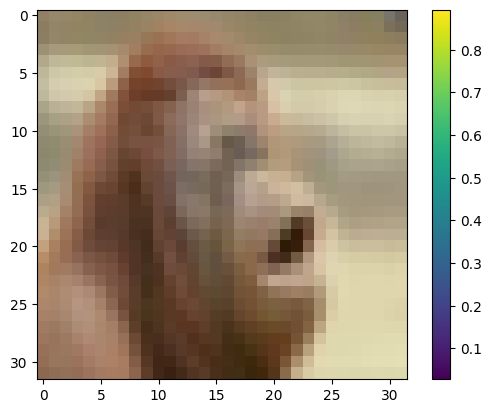

In [9]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

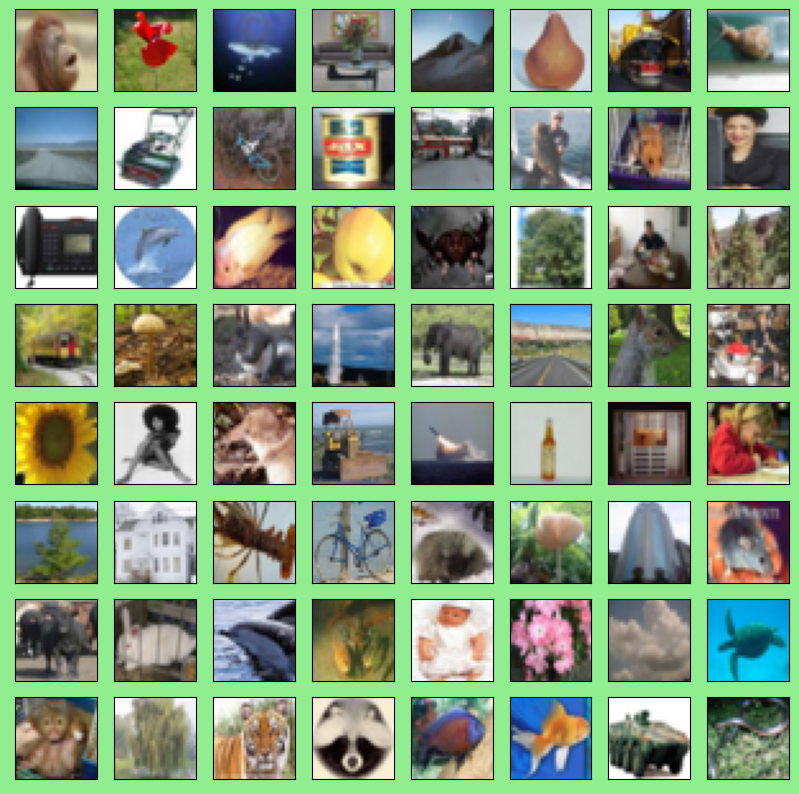

In [10]:
plt.figure(figsize=(10,10),facecolor="lightgreen")
for i in range(64): # 25 images
  plt.subplot(8,8,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
plt.show()

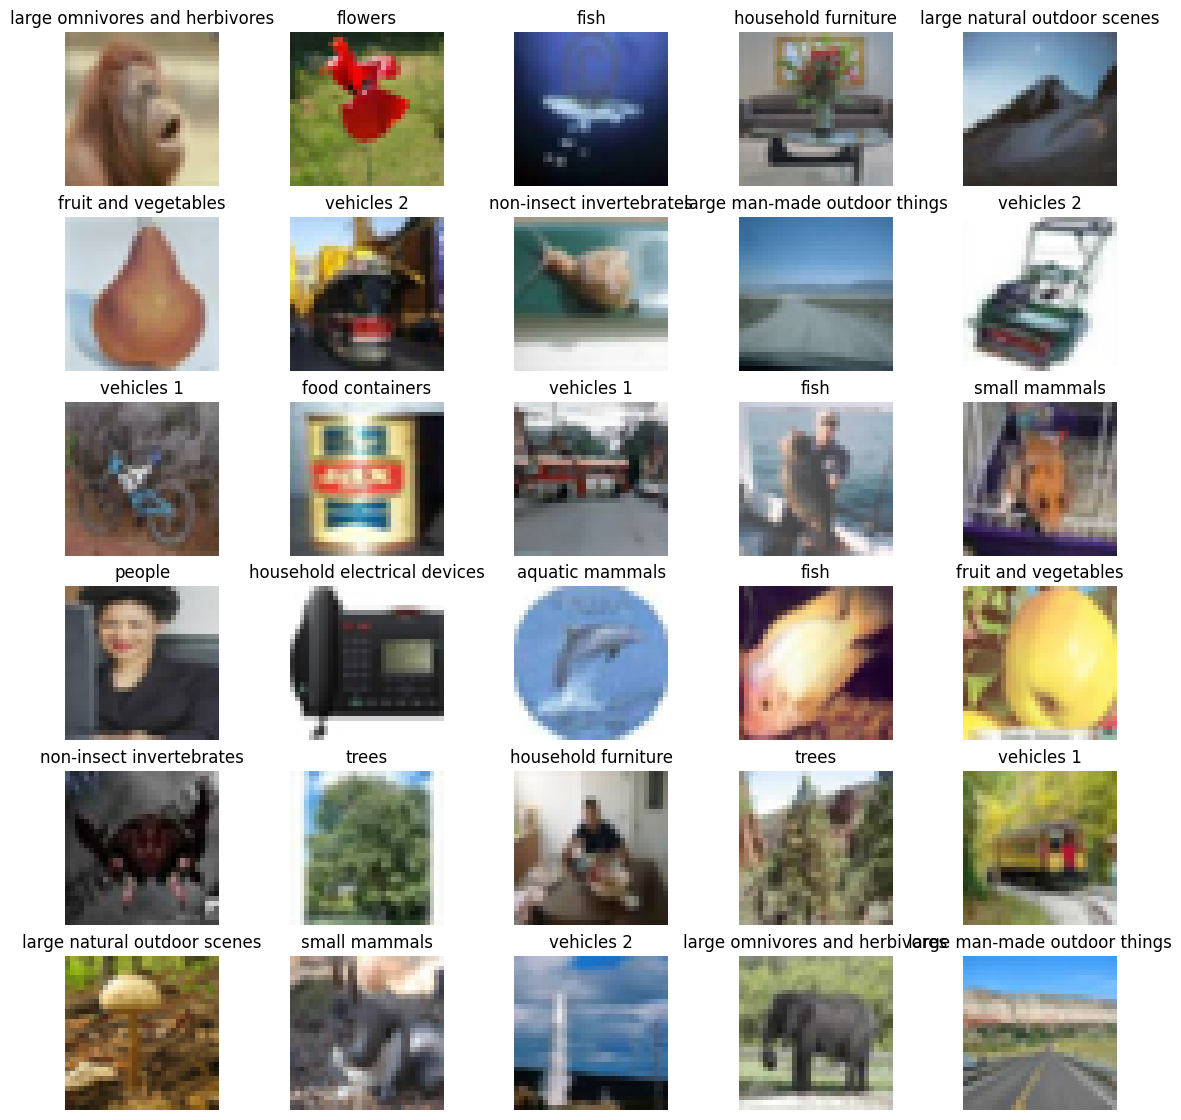

In [11]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    
    coarse_label_index = y_train_coarse[i][0]
    coarse_label = coarse_classnames[coarse_label_index]
    
    fine_label_index = y_train_fine[i][0]
    fine_label = fine_classnames[fine_label_index]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{coarse_label}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

In [12]:
unique, counts = np.unique(y_train_coarse, return_counts=True)
var = dict(zip(unique, counts))
for x in range(0,len(var)):
    var[coarse_classnames[x]] = var.pop(x)

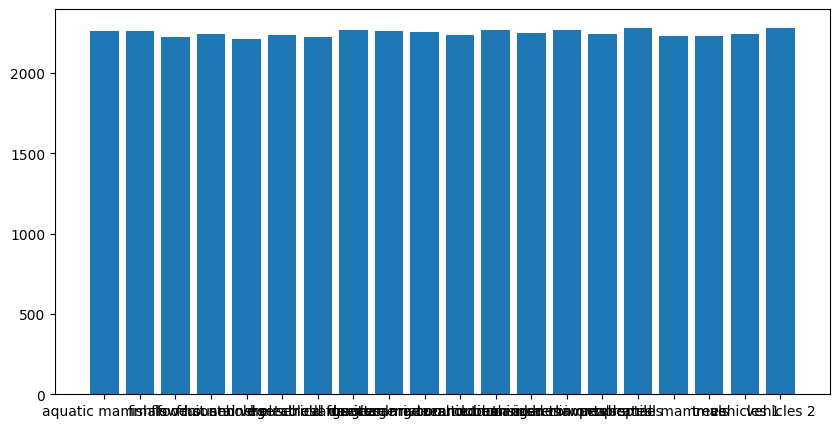

In [13]:
plt.figure(figsize=(10,5))
plt.bar(*zip(*var.items()))
plt.show()

* About 200 images per class, data is not imbalanced

## Objectives/Tasks

- Be able to accurately identify the test images fed to the model
- Get highest possible accuracy and loss (>90% accuracy)
- Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

In [14]:
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of x
        # =========================================================== #
        x = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            x[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                x = self.__augment_batch(x)                
            
            return x,y
        
        elif self.mode == 'predict':
            return x       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [16]:
gen = DataGenerator(x_train.copy())
x_train_aug = gen.augment_batch(x_train.copy())

x_train.shape, x_train_aug.shape

((45000, 32, 32, 3), (45000, 32, 32, 3))

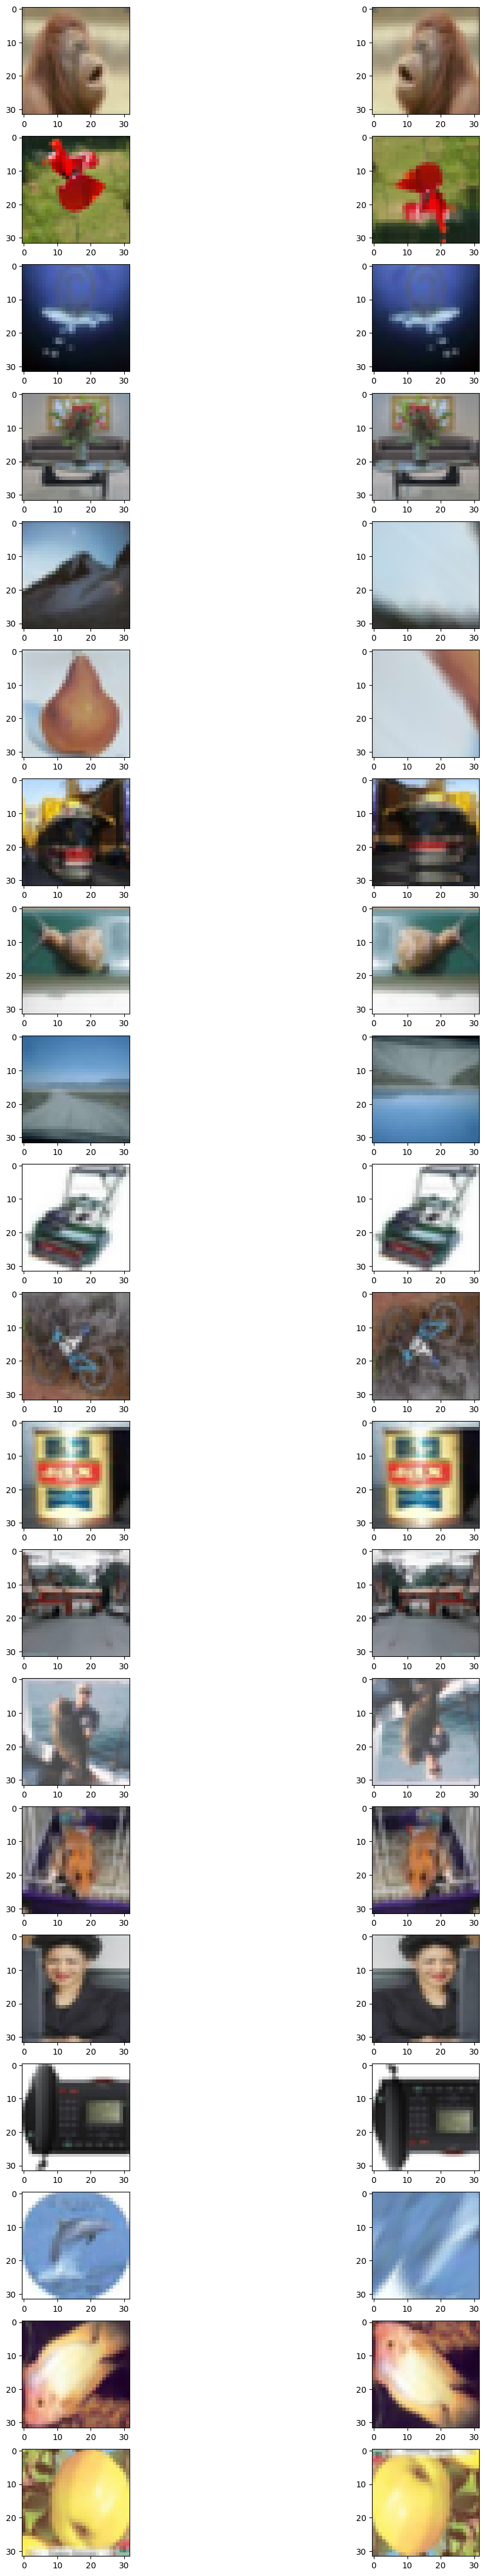

In [17]:

                    
import matplotlib.pyplot as plt

NUM_ROW = 20               # CHANGE THIS
NUM_COL = 2               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 56               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(20):
    a = x_train[i]
    b = x_train_aug[i]
    
    ax[i, 0].imshow(a, cmap=plt.cm.binary)
    ax[i, 1].imshow(b, cmap=plt.cm.binary)
        
plt.show()

In [18]:
x_train_aug_all = np.concatenate([x_train, x_train_aug], axis=0)
y_train_coarse_aug_all = np.concatenate([y_train_coarse, y_train_coarse], axis=0)
y_train_fine_aug_all = np.concatenate([y_train_fine, y_train_fine], axis=0)

x_train_aug_all.shape, y_train_coarse_aug_all.shape, y_train_fine_aug_all.shape

((90000, 32, 32, 3), (90000, 1), (90000, 1))

# Simple Baseline Model

### Baseline Coarse Model

In [19]:
baseline_coarse_model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(32, 32, 3)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(20)
    
])

#copy pasted from documentation
baseline_coarse_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

baseline_coarse_model.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_coarse.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_coarseAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baseline_coarseLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
baseline_coarse_model_history = baseline_coarse_model.fit(x_train, y_train_coarse, 
                                                epochs=10, 
                                                validation_data=(x_val, y_val_coarse), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

baseline_coarse_model_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        416       
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 20)                615060    
                                                                 
Total params: 615,476
Trainable params: 615,476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1394/1407 [============================>.] - ETA: 0s - loss: 2.2855 - accuracy: 0.3133
Epoch 1: saving model to tmp/checkpoint\baseline_coarse.hdf5

Epoch 1: val_accuracy improved from -inf to 0.35760, saving model to tmp/checkpoint\baseline_coarseAcc.hdf5

Epoch 1: val_loss improved from inf to 2.1389

In [20]:
# evaluating baseline coarse model
print(baseline_coarse_model.evaluate(x_test, y_test_coarse))
baseline_coarse_model.load_weights('tmp/checkpoint/baseline_coarseAcc.hdf5')
scoreAcc = baseline_coarse_model.evaluate(x_test, y_test_coarse)
baseline_coarse_model.load_weights('tmp/checkpoint/baseline_coarseLoss.hdf5')
scoreLoss = baseline_coarse_model.evaluate(x_test, y_test_coarse)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 2ms/step - loss: 2.3526 - accuracy: 0.3850
[2.352566957473755, 0.38499999046325684]
313/313 [==============================] - 1s 2ms/step - loss: 2.0479 - accuracy: 0.4014
Best Acc Test Loss: 2.0478787422180176
Best Acc Test Accuracy: 40.14 %
Best Loss Test Loss: 2.0478787422180176
Best Loss Test Accuracy: 40.14 %


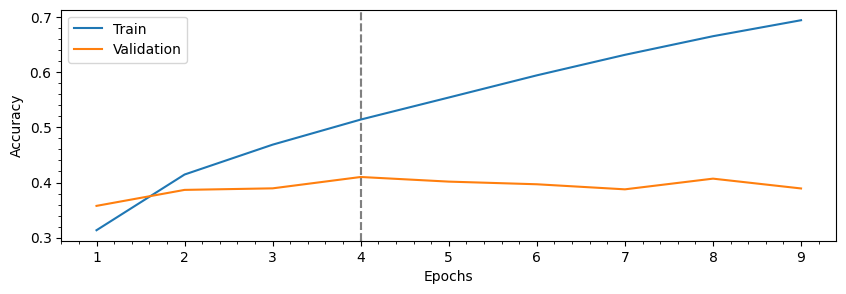

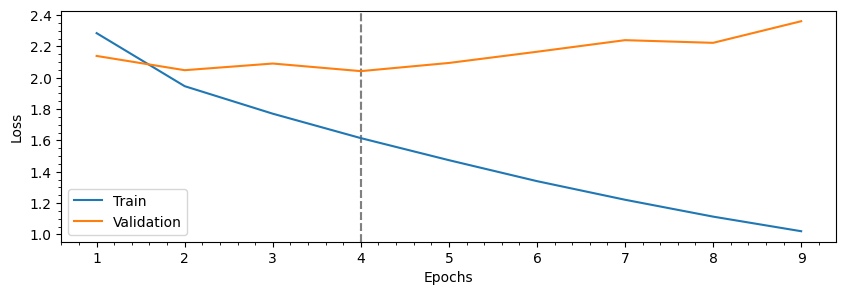

In [21]:
max_val_acc_epoch = np.argmax(list(baseline_coarse_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_coarse_model_history.history['val_loss']))+1
epochs = range(1, len(baseline_coarse_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_coarse_model_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_coarse_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_coarse_model_history.history['loss'], label='Train')
plt.plot(epochs,baseline_coarse_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

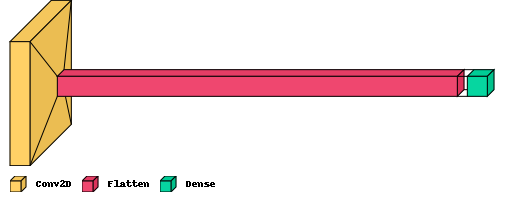

In [23]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_coarse_model, legend=True)

In [24]:
# baseline_coarse_model.save_weights("./models/baseline-coarse-model.h5")

### Baseline Fine Model

In [25]:
baseline_fine_model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(32, 32, 3)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(100)
])

#copy pasted from documentation
baseline_fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

baseline_fine_model.summary()

baseline_fine_model_history = baseline_fine_model.fit(x_train, y_train_fine, epochs=10, validation_data=(x_val, y_val_fine))
baseline_fine_model_history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        416       
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_1 (Dense)             (None, 100)               3075300   
                                                                 
Total params: 3,075,716
Trainable params: 3,075,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 3.5727 - accuracy: 0.1904 - val_loss: 3.1989 - val_accuracy: 0.2446
Epoch 2/10
1407/1407 [==============================] - 5s 3ms/step - loss: 2.6723 - accuracy: 0.3583 - val_loss: 3.0819 - val_accuracy: 0.2842
Epoch 3/10
1407/1407

In [26]:
# evaluating baseline modes
print(baseline_fine_model.evaluate(x_test, y_test_fine))

313/313 [==============================] - 1s 2ms/step - loss: 5.4367 - accuracy: 0.2534
[5.436721324920654, 0.2533999979496002]


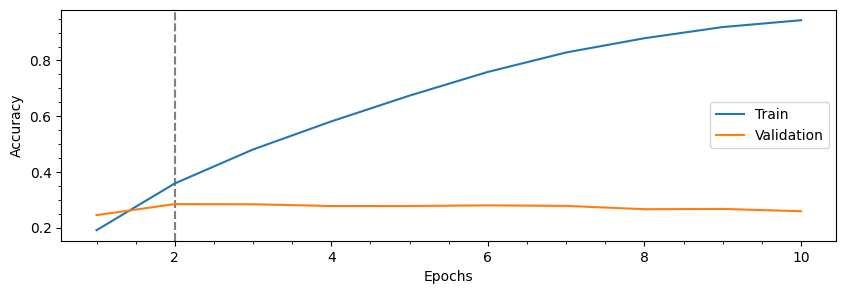

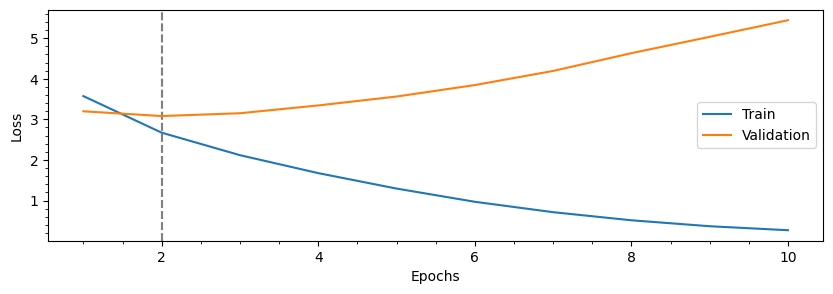

In [27]:
max_val_acc_epoch = np.argmax(list(baseline_fine_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_fine_model_history.history['val_loss']))+1
epochs = range(1, len(baseline_fine_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_fine_model_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_fine_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_fine_model_history.history['loss'], label='Train')
plt.plot(epochs,baseline_fine_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

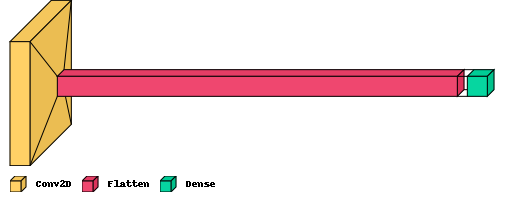

In [28]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_fine_model, legend=True)

In [29]:
baseline_fine_model.save_weights("./tmp/baseline-fine-model.h5")

# Own model - Coarse

In [30]:
own_coarse_model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
	layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.MaxPooling2D((2, 2)),
	layers.BatchNormalization(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(20)
])
VERSION = '00000002'
#copy pasted from documentation
own_coarse_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

own_coarse_model.summary()


checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_model_coarse.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_model_coarseAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_model_coarseLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
own_coarse_model_history = own_coarse_model.fit(x_train, y_train_coarse, 
                                                epochs=50, 
                                                validation_data=(x_val, y_val_coarse), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])
own_coarse_model_history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)       

In [31]:
# evaluating baseline coarse model
print(own_coarse_model.evaluate(x_test, y_test_coarse))
own_coarse_model.load_weights('tmp/checkpoint/own_model_coarseAcc.hdf5')
scoreAcc = own_coarse_model.evaluate(x_test, y_test_coarse)
own_coarse_model.load_weights('tmp/checkpoint/own_model_coarseLoss.hdf5')
scoreLoss = own_coarse_model.evaluate(x_test, y_test_coarse)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 4ms/step - loss: 1.6628 - accuracy: 0.6199
[1.6628388166427612, 0.6198999881744385]
313/313 [==============================] - 1s 4ms/step - loss: 1.3165 - accuracy: 0.6176
Best Acc Test Loss: 1.5205650329589844
Best Acc Test Accuracy: 63.01 %
Best Loss Test Loss: 1.3165313005447388
Best Loss Test Accuracy: 61.760000000000005 %


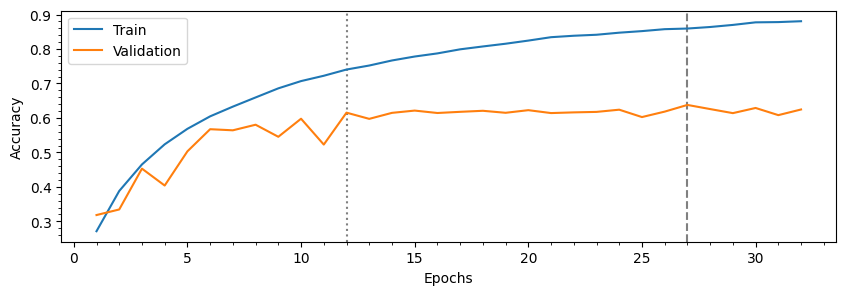

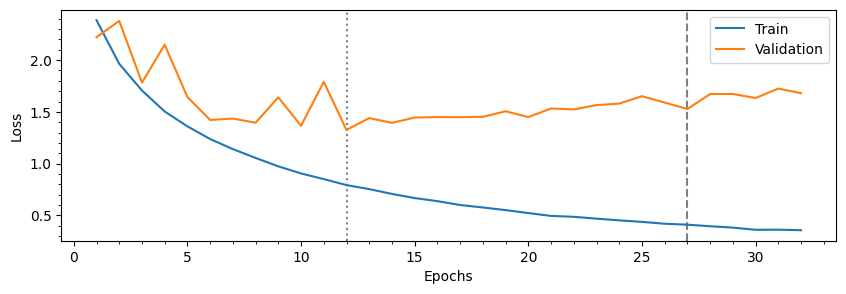

In [32]:
max_val_acc_epoch = np.argmax(list(own_coarse_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(own_coarse_model_history.history['val_loss']))+1
epochs = range(1, len(own_coarse_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_coarse_model_history.history['accuracy'], label='Train')
plt.plot(epochs,own_coarse_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_coarse_model_history.history['loss'], label='Train')
plt.plot(epochs,own_coarse_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

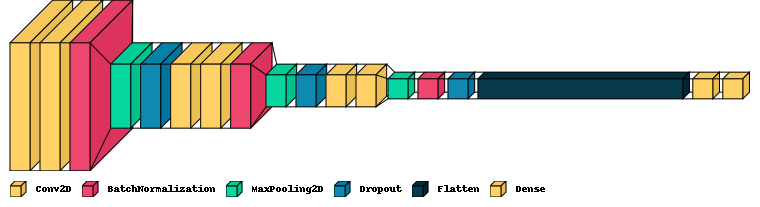

In [33]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_coarse_model, legend=True)

In [34]:
# own_coarse_model.save_weights("./tmp/checkpoint/own-coarse-model.h5")

In [35]:
saved_model_path = own_coarse_model.save(f"./tmp/{VERSION}", save_format='tf')

import subprocess 

subprocess.run([f"saved_model_cli show --dir ./tmp/{VERSION}/ --all"], shell=True)
subprocess.run([f"tar cvfz model.tar.gz tmp/{VERSION}/"], shell=True)

INFO:tensorflow:Assets written to: ./tmp/00000002\assets


INFO:tensorflow:Assets written to: ./tmp/00000002\assets


CompletedProcess(args=['tar cvfz model.tar.gz tmp/00000002/'], returncode=1)

## Own fine model

In [36]:
own_fine_model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
	layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.MaxPooling2D((2, 2)),
	layers.BatchNormalization(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(100)
])

#copy pasted from documentation
own_fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

own_fine_model.summary()

own_fine_model_history = own_fine_model.fit(x_train, y_train_fine, epochs=30, validation_data=(x_val, y_val_fine))
own_fine_model_history

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)       

In [37]:
# evaluating baseline coarse model
print(own_fine_model.evaluate(x_test, y_test_fine))

313/313 [==============================] - 1s 4ms/step - loss: 2.5640 - accuracy: 0.4914
[2.5639894008636475, 0.49140000343322754]


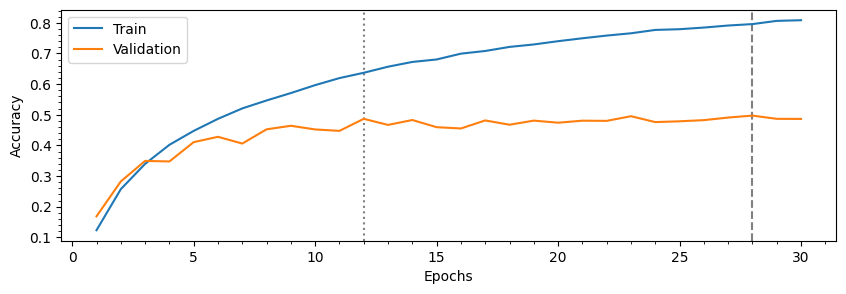

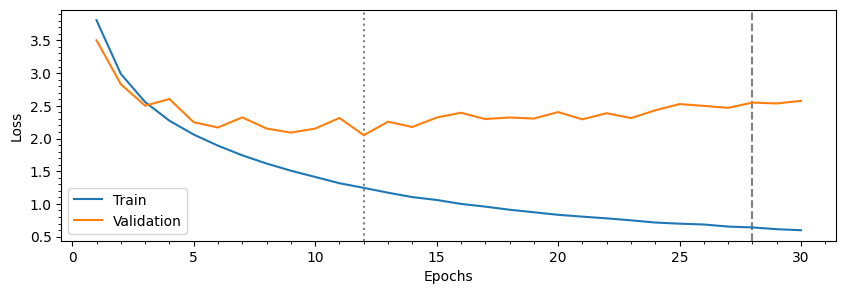

In [38]:
max_val_acc_epoch = np.argmax(list(own_fine_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(own_fine_model_history.history['val_loss']))+1
epochs = range(1, len(own_fine_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_fine_model_history.history['accuracy'], label='Train')
plt.plot(epochs,own_fine_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_fine_model_history.history['loss'], label='Train')
plt.plot(epochs,own_fine_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

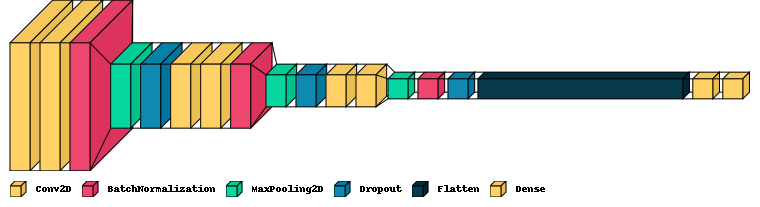

In [39]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_fine_model, legend=True)

In [40]:
own_fine_model.save_weights("./tmp/own-fine-model.h5")

## Dropout and Random Augmentation

In [41]:
def progressive_with_dropout_randaug(
    model,
    checkpoint,
    getAcc,
    getLoss,
    log,
    data_name="cifar10",
    total_epochs=36,
    batch_size=64,
    target_shapes=[128],
    dropouts=[0.4],
    dropout_layer=-2,
    magnitudes=[0]):
    
    stages = min([len(target_shapes), len(dropouts), len(magnitudes)])
    for stage, target_shape, dropout, magnitude in zip(range(stages), target_shapes, dropouts, magnitudes):
        print(">>>> stage: {}/{}, target_shape: {}, dropout: {}, magnitude: {}".format(stage + 1, stages, target_shape, dropout, magnitude))
        if len(dropouts) > 1 and isinstance(model.layers[dropout_layer], keras.layers.Dropout):
            print(">>>> Changing dropout rate to:", dropout)
            model.layers[dropout_layer].rate = dropout
        target_shape = (target_shape, target_shape)
        train_dataset, test_dataset = init_dataset(data_name=data_name, target_shape=target_shape, batch_size=batch_size, magnitude=magnitude, keep_shape=True)
        opt = tf.keras.optimizers.Adam()
        top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
        model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
        checkpoint = checkpoint
        getAcc = getAcc
        getLoss = getLoss
        log = log
        initial_epoch = stage * total_epochs // stages
        epochs = (stage + 1) * total_epochs // stages
        history = model.fit(
            train_dataset,
            epochs=epochs,
            initial_epoch=initial_epoch,
            validation_data=test_dataset,
        callbacks=[checkpoint,getAcc,getLoss,log],
        )

In [42]:
class ProcessImage:
    def __init__(self, target_shape=(300, 300), magnitude=0, keep_shape=False):
        self.target_shape, self.magnitude, self.keep_shape = target_shape, magnitude, keep_shape
        self.target_shape = target_shape if len(target_shape) == 2 else target_shape[:2]
        if magnitude > 0:
            from keras_efficientnet_v2 import augment
            translate_const, cutout_const = 100, 40
            print(
                ">>>> RandAugment: magnitude = %d, translate_const = %d, cutout_const = %d"
                % (magnitude, translate_const, cutout_const)
            )
            aa = augment.RandAugment(magnitude=magnitude, translate_const=translate_const, cutout_const=cutout_const)
            self.process = lambda img: aa.distort(img)
        elif magnitude == 0:
            self.process = lambda img: tf.image.random_flip_left_right(img)
        else:
            self.process = lambda img: img
    def __call__(self, datapoint):
        image = datapoint["image"]
        if self.keep_shape:
            cropped_shape = tf.reduce_min(tf.keras.backend.shape(image)[:2])
            image = tf.image.random_crop(image, (cropped_shape, cropped_shape, 3))
        input_image = tf.image.resize(image, self.target_shape,method = tf.image.ResizeMethod.BICUBIC)
        label = datapoint["label"]
        input_image = self.process(input_image)
        input_image = (tf.cast(input_image, tf.float32) - 127.5) / 128
        return input_image, label


def init_dataset(data_name="test123",target_shape=(300, 300), batch_size=64, all = 10000,buffer_size=1000, info_only=False, magnitude=0, keep_shape=False):
    train,test = tfds.load(data_name,split=['train','test'])
    dataset, info = tfds.load(data_name, with_info=True)
    num_classes = info.features["label"].num_classes
    total_images = info.splits["train"].num_examples
    if info_only:
        return total_images, num_classes

    AUTOTUNE = tf.data.AUTOTUNE
    train_process = ProcessImage(target_shape, magnitude, keep_shape=keep_shape)
    train = train.map(lambda xx: train_process(xx), num_parallel_calls=AUTOTUNE)

    test_process = ProcessImage(target_shape, magnitude=-1, keep_shape=keep_shape)
    test = test.map(lambda xx: test_process(xx))

    as_one_hot = lambda x, y: (x, tf.one_hot(y, num_classes))
    train_dataset = train.shuffle(buffer_size).batch(batch_size).map(as_one_hot).prefetch(buffer_size=AUTOTUNE)
    test_dataset = test.batch(batch_size).map(as_one_hot)
    return train_dataset,test_dataset

In [43]:
input = tf.keras.Input((32,32,3))
x = Conv2D(32,(3,3),(1,1),'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(64,(3,3),(2,2),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(100,'softmax')(x)
opt = tf.keras.optimizers.Adam()
general = keras.models.Model(inputs=input,outputs = x)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')

general.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
# log_base = CSVLogger('tmp/baselineB.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/general.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/general_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/general_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

In [44]:
input_shape = ( 32, 32, 3)
batch_size = 64
train_dataset, test_dataset = init_dataset(data_name="cifar100", target_shape=input_shape, batch_size=batch_size,magnitude=-1,keep_shape=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\p2100803\tensorflow_datasets\cifar100\3.0.2.incompleteER6D3V\cifar100-train.tfrecord*...:  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\p2100803\tensorflow_datasets\cifar100\3.0.2.incompleteER6D3V\cifar100-test.tfrecord*...:   …

Dataset cifar100 downloaded and prepared to C:\Users\p2100803\tensorflow_datasets\cifar100\3.0.2. Subsequent calls will reuse this data.


In [45]:
general_history = general.fit(train_dataset,epochs=50,validation_data=test_dataset,callbacks=[checkpoint,getAcc,getLoss])

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 3.3906 - accuracy: 0.1919 - top_3_accuracy: 0.3579
Epoch 1: saving model to tmp/checkpoint\general.hdf5

Epoch 1: val_accuracy improved from -inf to 0.21320, saving model to tmp/checkpoint\general_Acc.hdf5

Epoch 1: val_loss improved from inf to 3.19928, saving model to tmp/checkpoint\general_Loss.hdf5
782/782 [==============================] - 9s 10ms/step - loss: 3.3906 - accuracy: 0.1919 - top_3_accuracy: 0.3579 - val_loss: 3.1993 - val_accuracy: 0.2132 - val_top_3_accuracy: 0.3981
Epoch 2/50
779/782 [============================>.] - ETA: 0s - loss: 2.5354 - accuracy: 0.3417 - top_3_accuracy: 0.5612
Epoch 2: saving model to tmp/checkpoint\general.hdf5

Epoch 2: val_accuracy improved from 0.21320 to 0.35600, saving model to tmp/checkpoint\general_Acc.hdf5

Epoch 2: val_loss improved from 3.19928 to 2.46412, saving model to tmp/checkpoint\general_Loss.hdf5
782/782 [==============================] - 8s 10ms/step - l

In [46]:
general.load_weights('tmp/checkpoint/general_Acc.hdf5')
scoreAcc = general.evaluate(test_dataset)
general.load_weights('tmp/checkpoint/general_Loss.hdf5')
scoreLoss = general.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

157/157 [==============================] - 1s 4ms/step - loss: 2.0555 - accuracy: 0.4711 - top_3_accuracy: 0.6813
Best Acc Test Loss: 2.117631196975708
Best Acc Test Accuracy: 47.48 %
Best Loss Test Loss: 2.0555036067962646
Best Loss Test Accuracy: 47.11 %


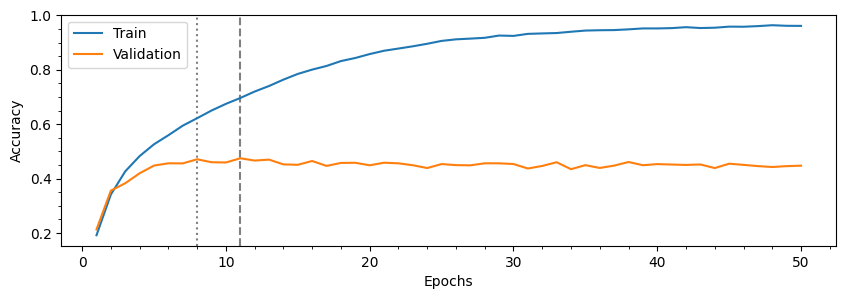

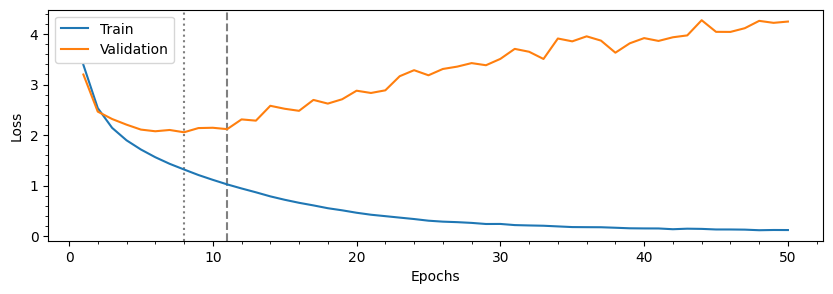

In [47]:
max_val_acc_epoch = np.argmax(general_history.history['val_accuracy'])+1
max_val_loss_epoch = np.argmin(general_history.history['val_loss'])+1
epochs = range(1, len(general_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,general_history.history['accuracy'], label='Train')
plt.plot(epochs,general_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,general_history.history['loss'], label='Train')
plt.plot(epochs,general_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

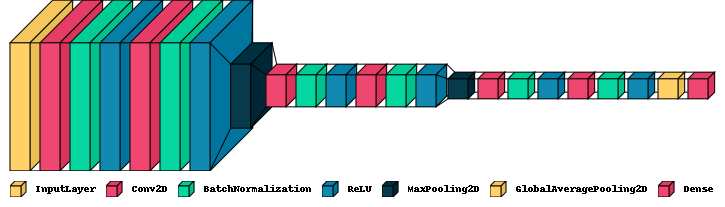

In [48]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(general, legend=True)

In [49]:
general.save_weights("./tmp/general-model.h5")

# Model Improvement

### Baseline Coarse Model with Augmented Data

In [50]:
# baseline model + augmented data
baseline_coarse_model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(32, 32, 3)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(20)
])
# optimizer = Adam(lr=0.0001)
#copy pasted from documentation
baseline_coarse_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 15, factor= 0.5, min_lr= 1e-6, verbose=1)

#model compiling
# baseline_coarse_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
baseline_coarse_model.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselinecoarse.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselinecoarseAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselinecoarseLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
baseline_coarse_model_history = baseline_coarse_model.fit(x_train_aug_all, y_train_coarse_aug_all, 
                                                epochs=100, 
                                                validation_data=(x_val, y_val_coarse), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                rlrop, early_stop])
baseline_coarse_model_history

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 31, 31, 32)        416       
                                                                 
 flatten_4 (Flatten)         (None, 30752)             0         
                                                                 
 dense_7 (Dense)             (None, 20)                615060    
                                                                 
Total params: 615,476
Trainable params: 615,476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2809/2813 [============================>.] - ETA: 0s - loss: 2.3880 - accuracy: 0.2864
Epoch 1: saving model to tmp/checkpoint\baselinecoarse.hdf5

Epoch 1: val_accuracy improved from -inf to 0.36980, saving model to tmp/checkpoint\baselinecoarseAcc.hdf5

Epoch 1: val_loss improved from inf to 2.119

In [51]:
# evaluating baseline coarse model
print(baseline_coarse_model.evaluate(x_test, y_test_coarse))
baseline_coarse_model.load_weights('tmp/checkpoint/baselinecoarseAcc.hdf5')
scoreAcc = baseline_coarse_model.evaluate(x_test, y_test_coarse)
baseline_coarse_model.load_weights('tmp/checkpoint/baselinecoarseLoss.hdf5')
scoreLoss = baseline_coarse_model.evaluate(x_test, y_test_coarse)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 2ms/step - loss: 2.0955 - accuracy: 0.3725
[2.0955328941345215, 0.3725000023841858]
313/313 [==============================] - 1s 2ms/step - loss: 2.0955 - accuracy: 0.3725
Best Acc Test Loss: 2.107391119003296
Best Acc Test Accuracy: 37.89 %
Best Loss Test Loss: 2.0955328941345215
Best Loss Test Accuracy: 37.25 %


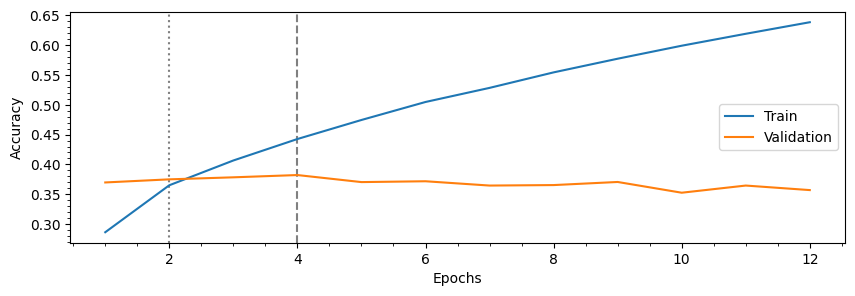

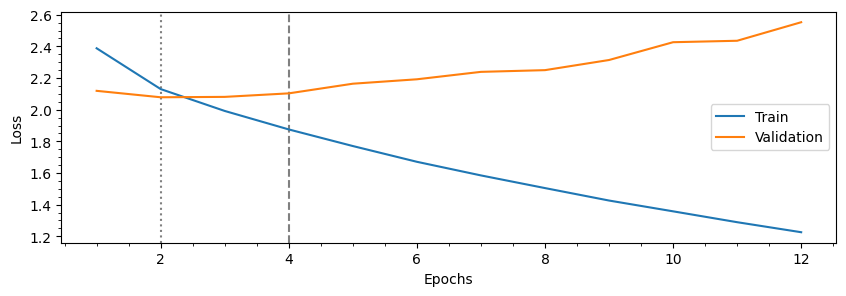

In [52]:
max_val_acc_epoch = np.argmax(list(baseline_coarse_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_coarse_model_history.history['val_loss']))+1
epochs = range(1, len(baseline_coarse_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_coarse_model_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_coarse_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_coarse_model_history.history['loss'], label='Train')
plt.plot(epochs,baseline_coarse_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

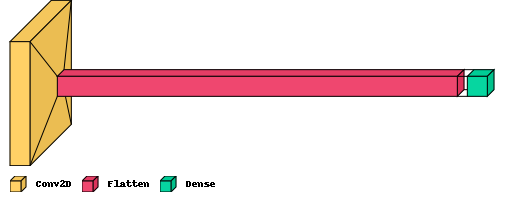

In [53]:

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_coarse_model, legend=True)

### Own Coarse Model with Data Augmentation


In [54]:
own_coarse_model_augmented = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
	layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.MaxPooling2D((2, 2)),
	layers.BatchNormalization(),
	# layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
	# layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
	# layers.MaxPooling2D((2, 2)),
	# layers.BatchNormalization(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.Dense(20)
])
VERSION = '00000001'
own_coarse_model_augmented.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

own_coarse_model_augmented.summary()


#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_coarse.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_coarseAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_coarseLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
own_coarse_model_augmented_history = own_coarse_model_augmented.fit(x_train_aug_all, y_train_coarse_aug_all, 
                                                epochs=30, 
                                                validation_data=(x_val, y_val_coarse), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                early_stop, rlrop])
own_coarse_model_augmented_history

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 64)       

In [55]:
# evaluating baseline coarse model
print(own_coarse_model_augmented.evaluate(x_test, y_test_coarse))
own_coarse_model_augmented.load_weights('tmp/checkpoint/own_modelAug_coarseAcc.hdf5')
scoreAcc = own_coarse_model_augmented.evaluate(x_test, y_test_coarse)
own_coarse_model_augmented.load_weights('tmp/checkpoint/own_modelAug_coarseLoss.hdf5')
scoreLoss = own_coarse_model_augmented.evaluate(x_test, y_test_coarse)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 4ms/step - loss: 1.2413 - accuracy: 0.6171
[1.2412949800491333, 0.6171000003814697]
313/313 [==============================] - 1s 4ms/step - loss: 1.2413 - accuracy: 0.6171
Best Acc Test Loss: 1.2844324111938477
Best Acc Test Accuracy: 65.3 %
Best Loss Test Loss: 1.2412949800491333
Best Loss Test Accuracy: 61.71 %


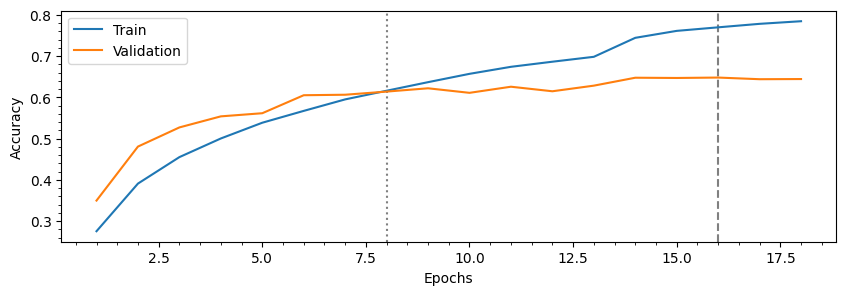

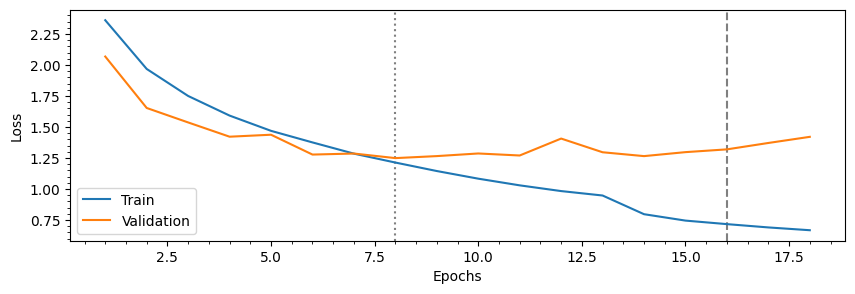

In [56]:
max_val_acc_epoch = np.argmax(list(own_coarse_model_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(own_coarse_model_augmented_history.history['val_loss']))+1
epochs = range(1, len(own_coarse_model_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_coarse_model_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,own_coarse_model_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_coarse_model_augmented_history.history['loss'], label='Train')
plt.plot(epochs,own_coarse_model_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
own_coarse_model_augmented.save_weights("./tmp/own-coarse-aug-model.h5")

In [58]:
saved_model_path = own_coarse_model_augmented.save(f"./tmp/{VERSION}", save_format='tf')

INFO:tensorflow:Assets written to: ./tmp/00000001\assets


INFO:tensorflow:Assets written to: ./tmp/00000001\assets


In [59]:
import subprocess 

subprocess.run([f"saved_model_cli show --dir ./tmp/{VERSION}/ --all"], shell=True)
subprocess.run([f"tar cvfz model.tar.gz tmp/{VERSION}/"], shell=True)

CompletedProcess(args=['tar cvfz model.tar.gz tmp/00000001/'], returncode=1)

In [60]:

# from google.colab import files

# files.download('model.tar.gz')

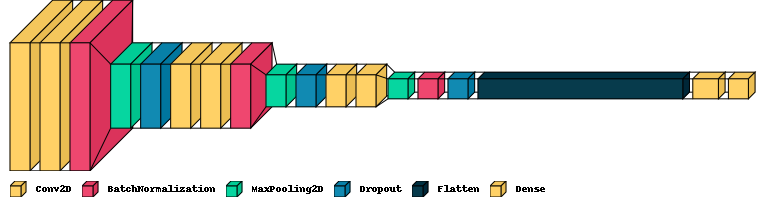

In [61]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_coarse_model_augmented, legend=True)

## Own Fine Augmented Model

In [62]:
own_fine_model_augmented = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
	layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Dropout(0.2),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	layers.MaxPooling2D((2, 2)),
	layers.BatchNormalization(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(100)
])

#copy pasted from documentation
own_fine_model_augmented.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

own_fine_model_augmented.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_fine.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_fineAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/own_modelAug_fineLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
own_fine_model_augmented_history = own_fine_model_augmented.fit(x_train_aug_all, y_train_fine_aug_all, 
                                                epochs=30, 
                                                validation_data=(x_val, y_val_fine), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                early_stop, rlrop])
own_fine_model_augmented_history

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 64)       

In [63]:
# evaluating baseline coarse model
print(own_fine_model_augmented.evaluate(x_test, y_test_fine))
own_fine_model_augmented.load_weights('tmp/checkpoint/own_modelAug_fineAcc.hdf5')
scoreAcc = own_fine_model_augmented.evaluate(x_test, y_test_fine)
own_fine_model_augmented.load_weights('tmp/checkpoint/own_modelAug_fineLoss.hdf5')
scoreLoss = own_fine_model_augmented.evaluate(x_test, y_test_fine)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 4ms/step - loss: 1.8803 - accuracy: 0.5126
[1.880268931388855, 0.5126000046730042]
313/313 [==============================] - 1s 4ms/step - loss: 1.8803 - accuracy: 0.5126
Best Acc Test Loss: 1.955142617225647
Best Acc Test Accuracy: 53.04 %
Best Loss Test Loss: 1.880268931388855
Best Loss Test Accuracy: 51.25999999999999 %


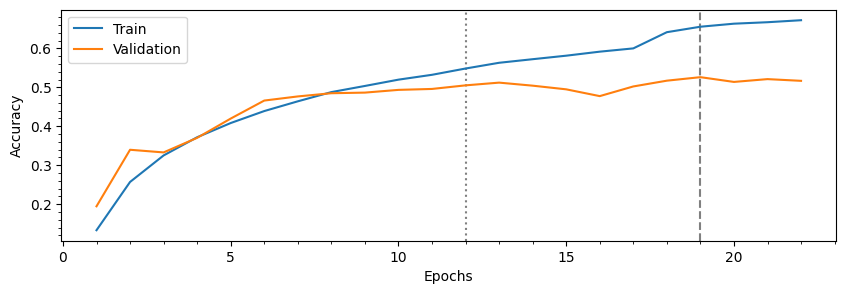

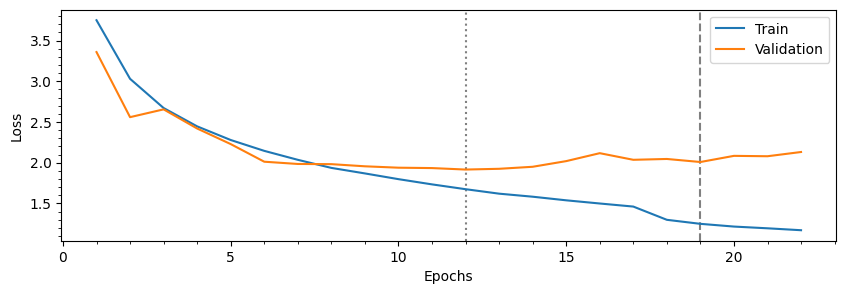

In [64]:
max_val_acc_epoch = np.argmax(list(own_fine_model_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(own_fine_model_augmented_history.history['val_loss']))+1
epochs = range(1, len(own_fine_model_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_fine_model_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,own_fine_model_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,own_fine_model_augmented_history.history['loss'], label='Train')
plt.plot(epochs,own_fine_model_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

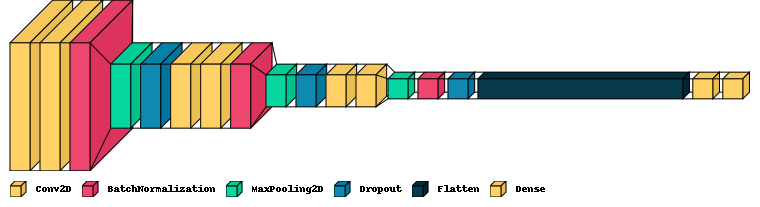

In [65]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_fine_model_augmented, legend=True)

## Resnet50 

In [66]:
# ATTENTION. train using school lab computer with GPU

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50(num_class):
    input_im = Input(shape=(32,32,3))
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(num_class, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

resnet50_model = resnet50(20)
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [67]:
import scipy
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_lab_categorical_coarse = tf.keras.utils.to_categorical(
    y_train_coarse_aug_all, num_classes=20, dtype='uint8')

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

train_set_conv = train_DataGen.flow(x_train_aug_all, train_lab_categorical_coarse, batch_size=batch_size)

resnet_coarse_history = resnet50_model.fit(train_set_conv, epochs=30, callbacks=[early_stop])

Epoch 1/30
 994/1407 [====================>.........] - ETA: 19s - loss: 13.8139 - acc: 0.1430

KeyboardInterrupt: 

In [ ]:
resnet50_model.evaluate(x=x_test, y=tf.keras.utils.to_categorical(
    y_test_coarse, num_classes=20, dtype='uint8'))

313/313 [==============================] - 10s 26ms/step - loss: 1.8317 - acc: 0.4759


[1.8317431211471558, 0.47589999437332153]

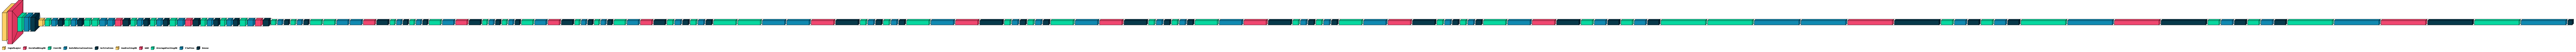

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(resnet50_model, legend=True)

In [ ]:
resnet50_model.save_weights("./tmp/resnet50-coarse-model.h5")

In [ ]:
# # fine model
# resnet50_model_fine = resnet50(100)
# resnet50_model_fine.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
#                        metrics=['acc'])

# import scipy
# train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
#                                                                 width_shift_range=0.1, 
#                                                                 height_shift_range = 0.1, 
#                                                                 horizontal_flip=True)
# batch_size=64

# train_lab_categorical_fine = tf.keras.utils.to_categorical(
#     y_train_fine_aug_all, num_classes=100, dtype='uint8')

# train_set_conv = train_DataGen.flow(x_train_aug_all, train_lab_categorical_fine, batch_size=batch_size)

# resnet_fine_history = resnet50_model_fine.fit(train_set_conv, epochs=50)


In [ ]:
# resnet50_model_fine.evaluate(x=x_test, y=tf.keras.utils.to_categorical(
#     y_test_fine, num_classes=100, dtype='uint8'))

In [ ]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(resnet50_model_fine, legend=True)

In [ ]:
# resnet50_model_fine.save_weights("./tmp/resnet50-fine-model.h5")

## Parameters

In [ ]:
# optimizer = Adam(lr=0.0001)

# #early stopping to monitor the validation loss and avoid overfitting
# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

# #reducing learning rate on plateau
# rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

# #model compiling
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])